# Ground Truth CSV Clean Up Notebook

In [1]:
# Install necessary libraries needed
%pip install regex numpy datasets pandas matplotlib thefuzz python-Levenshtein

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import os  
import Levenshtein
from datasets import load_dataset
from datetime import datetime  
import re 
import regex # For any edge cases just in case  
import difflib 
from dataclasses import dataclass

### Set Up Constants and Configuration

In [3]:
# Set up CSV path and other paths.  

GT_FILE    = "../../data/ground_truth/v4_255_(1993)_(2-14-2026).csv"
OUTPUT_DIR = "../../data/clean_ground_truth"
LOG_DIR    = "../../data/logs/difflib"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)


In [4]:
# Set Up Constants 
NULL_SENTINELS  = {"NOT_FOUND", "NULL", "NONE", "NAN", ""}
ERROR_SENTINELS = {"JSON_PARSE_ERROR", "PARSE_ERROR", "NO_CONTENT", "NO_TEXT"}
ALL_SENTINELS   = NULL_SENTINELS | ERROR_SENTINELS 

SECTION_KEYS = [
    "section_1", "section_1A", "section_1B", "section_2",  "section_3",
    "section_4", "section_5",  "section_6",  "section_7",  "section_7A",
    "section_8", "section_9",  "section_9A", "section_9B", "section_10",
    "section_11","section_12", "section_13", "section_14", "section_15",
] 

MAX_ANCHOR_PASSES   = 3 
SHORT_EVIDENCE_THRESHOLD = 25

### Load DataFrame, Drop Initial Columns, & Grab Field IDs

In [5]:
# Load extracted EDGAR_GT CSV
df = pd.read_csv(GT_FILE) 
print(f"Loaded {len(df)} rows from {GT_FILE}") 
ORIGINAL_ROW_COUNT = len(df)

Loaded 255 rows from ../../data/ground_truth/v4_255_(1993)_(2-14-2026).csv


In [6]:
# Drop IRS Tax ID columns (If they exist, were not a good decision to extract)
irs_cols = [c for c in df.columns if "irs_tax_id" in c]
df.drop(columns=irs_cols, inplace=True)
print(f"Dropped IRS Tax ID columns: {irs_cols}")

Dropped IRS Tax ID columns: ['irs_tax_id_value', 'irs_tax_id_evidence', 'irs_tax_id_source_sentence', 'irs_tax_id_evidence_verified', 'irs_tax_id_found']


In [7]:
# Derive field IDs from DataFrame directly (no hardcoded lists)

FIELD_IDS = sorted(
    {c.replace("_value", "") for c in df.columns if c.endswith("_value")}
)
print(f"Discovered {len(FIELD_IDS)} field IDs: {FIELD_IDS}")

Discovered 9 field IDs: ['ceo_lastname', 'employees_count_full_time', 'employees_count_total', 'headquarters_city', 'headquarters_state', 'holder_record_amount', 'incorporation_state', 'incorporation_year', 'registrant_name']


In [8]:
# Check and Add Missing EDGAR Sections


def get_missing_sections(
    df: pd.DataFrame, section_keys: list[str] = SECTION_KEYS
) -> list[str]:
    """Returns section column names not present in df."""
    return [s for s in section_keys if s not in df.columns]


def append_missing_sections(
    df: pd.DataFrame,
    section_keys: list[str] = SECTION_KEYS,
    hf_dataset: str = "c3po-ai/edgar-corpus",
) -> pd.DataFrame:
    missing_keys = get_missing_sections(df, section_keys)

    if not missing_keys:
        print("Sections columns already present")
        return df

    print(
        f"{len(missing_keys)} section column(s) missing. Streaming from HuggingFace..."
    )

    for key in missing_keys:
        df[key] = pd.Series(dtype="object")

    needed_files = set(df["filename"].values)
    file_data = {}
    dataset = load_dataset(hf_dataset, "default", split="train", streaming=True)

    count = 0

    for doc in dataset:
        if doc["filename"] in needed_files:
            file_data[doc["filename"]] = doc
            count += 1
            if count >= len(needed_files):
                break
    for key in missing_keys:
        df[key] = df["filename"].map(lambda x, k=key: file_data.get(x, {}).get(k, np.nan))


    found = df["filename"].isin(file_data).sum()
    print(f"Matched {found}/{len(df)} rows to EDGAR sections.")

    return df

In [9]:
df = append_missing_sections(df)

Sections columns already present


### Standardizing Nulls and Source Sentences

In [10]:
def standardize_sentinels(df: pd.DataFrame, field_ids: list[str]) -> pd.DataFrame:
    """Replace all sentinel strings with np.nan across _value, _evidence, _source_sentence columns."""
    suffixes = ["_value", "_evidence", "_source_sentence"]
    for field in field_ids:
        for suffix in suffixes:
            col = f"{field}{suffix}"
            if col in df.columns:
                mask = df[col].astype(str).str.strip().str.upper().isin(ALL_SENTINELS)
                df.loc[mask, col] = np.nan 
        mask = df[f"{field}_value"].isna()
        df.loc[mask, f"{field}_evidence"] = np.nan
        df.loc[mask, f"{field}_source_sentence"] = np.nan
    return df

In [11]:
def ensure_source_sentence(df: pd.DataFrame, field_ids: list[str]) -> pd.DataFrame:
    """
    Ensure every field has a _source_sentence column.
    - If it already exists: do nothing.
    - If it doesn't exist and _evidence is present: use _evidence as the initial value.
    - Otherwise: create as np.nan and warn.
    """
    for field in field_ids:
        source_sentence_col = f"{field}_source_sentence"
        evidence_col = f"{field}_evidence"
        
        if source_sentence_col in df.columns:
            # Already exists — nothing to do
            continue
        
        if evidence_col in df.columns:
            # Backfill from evidence as a starting point for anchoring later
            df[source_sentence_col] = df[evidence_col].copy()
            print(f"  [INFO] '{source_sentence_col}' missing — initialized from '{evidence_col}'")
        else:
            # No source of truth at all — create blank column
            df[source_sentence_col] = pd.Series(dtype="object")
            print(f"  [WARN] '{source_sentence_col}' missing and no evidence found — column created as NaN")
    
    return df

In [12]:
print("=== Step 3: Standardize Nulls ===")
df = standardize_sentinels(df, FIELD_IDS)
df = ensure_source_sentence(df, FIELD_IDS)
print(f"Done. DataFrame shape: {df.shape}")

=== Step 3: Standardize Nulls ===
Done. DataFrame shape: (255, 68)


### Pre-Anchor Analysis Metrics and Visualization

#### Helper Functions

In [13]:
# Verification helper functions
def verify_in_sections(
    row: pd.Series, sentence: str, section_keys: list[str]
) -> str | None:
    """
    Check if a sentence exists as a substring in any EDGAR section for a given row.
    This is the core verification primitive. It answers: "Does this source sentence
    actually appear in the original 10-K filing text?"
    Args:
        row: A single DataFrame row containing section columns (section_1, section_1A, etc.)
        sentence: The source sentence to search for.
        section_keys: List of section column names to search through.
    Returns:
        The section column name where the sentence was found (e.g. "section_7"),
        or None if the sentence wasn't found in any section.
    """
    if not isinstance(sentence, str) or pd.isna(sentence):
        return None
    for section_name in section_keys:
        section_text = row.get(section_name)
        if pd.notna(section_text) and sentence in str(section_text):
            return section_name
    return None


def run_verification(
    df: pd.DataFrame, field_ids: list[str], section_keys: list[str]
) -> pd.DataFrame:
    """
    For each field, check if its source_sentence exists in any EDGAR section.
    Writes the result into a new {field}_section column.
    This is a READ-ONLY operation on the source data — it only reads _source_sentence
    and section columns, and writes to _section columns. It does NOT modify
    source sentences or evidence. Step 5 (anchor loop) is the step that modifies those.
    Args:
        df: DataFrame with source_sentence and section columns.
        field_ids: List of field ID strings (e.g. ["registrant_name", "ceo_lastname"]).
        section_keys: List of section column names to search (e.g. ["section_1", ...]).
    Returns:
        The same DataFrame with {field}_section columns populated.
    """
    for field_id in field_ids:
        source_col = f"{field_id}_source_sentence"
        section_col = f"{field_id}_section"
        # Build the section column row-by-row using verify_in_sections
        results = []
        for row_index in range(len(df)):
            row = df.iloc[row_index]
            source_sentence = row.get(source_col)
            if pd.notna(source_sentence):
                matched_section = verify_in_sections(row, source_sentence, section_keys)
                results.append(matched_section)
            else:
                results.append(None)
        df[section_col] = results
    return df

In [14]:
def compute_field_stats(
    df: pd.DataFrame, field_ids: list[str], label: str
) -> pd.DataFrame:
    """
    Compute per-field coverage statistics by reading _value, _source_sentence,
    and _section columns. Does not call verify_in_sections — expects _section
    columns to already be populated by run_verification().
    Each row falls into exactly one of four categories:
        1. Verified & Sourced — value present, source sentence present, AND found in a section
        2. Has Source, Unverified — value + source sentence present, but NOT found in any section
        3. Value, No Source — value present but source_sentence is NaN (anchoring gap)
        4. Valid Negative — value itself is NaN (legitimate missing data)
    Args:
        df: DataFrame with _value, _source_sentence, and _section columns.
        field_ids: List of field ID strings.
        label: Label for the printed header (e.g. "PRE-ANCHOR" or "POST-ANCHOR").
    Returns:
        A summary DataFrame with one row per field and columns for each category count.
    """
    records = []
    total_rows = len(df)
    for field_id in field_ids:
        value_col = f"{field_id}_value"
        source_col = f"{field_id}_source_sentence"
        section_col = f"{field_id}_section"
        # Boolean masks for each condition
        has_value = df[value_col].notna()
        has_source = has_value & df[source_col].notna()
        is_verified = has_source & df[section_col].notna()
        # Count each category
        num_has_value = int(has_value.sum())
        num_verified = int(is_verified.sum())
        num_has_source = int(has_source.sum())
        num_unverified = num_has_source - num_verified
        num_no_source = num_has_value - num_has_source
        num_valid_negative = total_rows - num_has_value
        # Source coverage: what % of rows with a value also have a source sentence?
        source_coverage_pct = (
            (num_has_source / num_has_value * 100) if num_has_value > 0 else 0.0
        )
        records.append(
            {
                "field": field_id,
                "total": total_rows,
                "verified_sourced": num_verified,
                "has_source_unverified": num_unverified,
                "value_no_source": num_no_source,
                "valid_negative": num_valid_negative,
                "source_pct": source_coverage_pct,
            }
        )
    stats_df = pd.DataFrame(records)
    # Print a formatted summary table
    print(f"\n{'=' * 70}")
    print(f"  {label} — Field Coverage Summary")
    print(f"{'=' * 70}")
    for _, row in stats_df.iterrows():
        print(
            f"  {row['field']:30s}  "
            f"verified={int(row['verified_sourced']):>3d}  "
            f"unverified={int(row['has_source_unverified']):>3d}  "
            f"no_source={int(row['value_no_source']):>3d}  "
            f"negative={int(row['valid_negative']):>3d}  "
            f"coverage={row['source_pct']:.0f}%"
        )
    print(f"{'=' * 70}\n")
    return stats_df

In [15]:
def plot_field_coverage(stats_df: pd.DataFrame, label: str) -> None:
    """
    Horizontal stacked bar chart showing the 4-category breakdown per field.
    Bars are sorted so the most-verified fields appear at the top. Horizontal
    orientation is used because field names (e.g. "employees_count_full_time")
    are long and would overlap on a vertical x-axis.
    Args:
        stats_df: Output from compute_field_stats().
        label: Appears in the chart title (e.g. "PRE-ANCHOR").
    """
    # Sort ascending so the highest values appear at the top of the chart
    sorted_stats = stats_df.sort_values("verified_sourced", ascending=True)
    field_names = sorted_stats["field"].values
    chart_height = max(6, len(sorted_stats) * 0.4)
    fig, ax = plt.subplots(figsize=(12, chart_height))
    y_positions = range(len(sorted_stats))
    # Extract each category's counts as arrays for stacking
    verified_counts = sorted_stats["verified_sourced"].values
    unverified_counts = sorted_stats["has_source_unverified"].values
    no_source_counts = sorted_stats["value_no_source"].values
    negative_counts = sorted_stats["valid_negative"].values
    # Stack bars left-to-right: verified → unverified → no_source → valid_negative
    ax.barh(y_positions, verified_counts, label="Verified & Sourced", color="#2ecc71")
    ax.barh(
        y_positions,
        unverified_counts,
        left=verified_counts,
        label="Has Source, Unverified",
        color="#f1c40f",
    )
    ax.barh(
        y_positions,
        no_source_counts,
        left=verified_counts + unverified_counts,
        label="Value, No Source",
        color="#e67e22",
    )
    ax.barh(
        y_positions,
        negative_counts,
        left=verified_counts + unverified_counts + no_source_counts,
        label="Valid Negative",
        color="#ecf0f1",
        edgecolor="#bdc3c7",
    )
    ax.set_yticks(y_positions)
    ax.set_yticklabels(field_names)
    ax.set_xlabel("Number of Rows")
    ax.set_title(f"Field Coverage — {label}")
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [16]:
def print_coverage_delta(pre_stats: pd.DataFrame, post_stats: pd.DataFrame) -> None:
    """
    Print a before/after comparison showing how anchoring improved coverage.
    Only used in Step 6, after both pre_stats and post_stats exist.
    Args:
        pre_stats: Output from compute_field_stats() run BEFORE anchoring.
        post_stats: Output from compute_field_stats() run AFTER anchoring.
    """
    print(f"\n{'=' * 70}")
    print("  ANCHORING DELTA — Pre vs Post")
    print(f"{'=' * 70}")
    merged = pre_stats.merge(post_stats, on="field", suffixes=("_pre", "_post"))
    for _, row in merged.iterrows():
        pre_verified = int(row["verified_sourced_pre"])
        post_verified = int(row["verified_sourced_post"])
        delta = post_verified - pre_verified
        sign = "+" if delta >= 0 else ""
        print(
            f"  {row['field']:30s}  "
            f"verified {pre_verified:>3d} → {post_verified:>3d} ({sign}{delta})  |  "
            f"coverage {row['source_pct_pre']:.0f}% → {row['source_pct_post']:.0f}%"
        )
    print(f"{'=' * 70}\n")

Running pre-anchor verification...

  PRE-ANCHOR — Field Coverage Summary
  ceo_lastname                    verified=173  unverified= 33  no_source=  0  negative= 49  coverage=100%
  employees_count_full_time       verified= 58  unverified=  2  no_source=  0  negative=195  coverage=100%
  employees_count_total           verified=166  unverified= 11  no_source=  0  negative= 78  coverage=100%
  headquarters_city               verified=159  unverified=  7  no_source=  0  negative= 89  coverage=100%
  headquarters_state              verified=154  unverified=  7  no_source=  0  negative= 94  coverage=100%
  holder_record_amount            verified=159  unverified=  5  no_source=  0  negative= 91  coverage=100%
  incorporation_state             verified=184  unverified=  5  no_source=  0  negative= 66  coverage=100%
  incorporation_year              verified=181  unverified=  4  no_source=  0  negative= 70  coverage=100%
  registrant_name                 verified=233  unverified= 16  no_sou

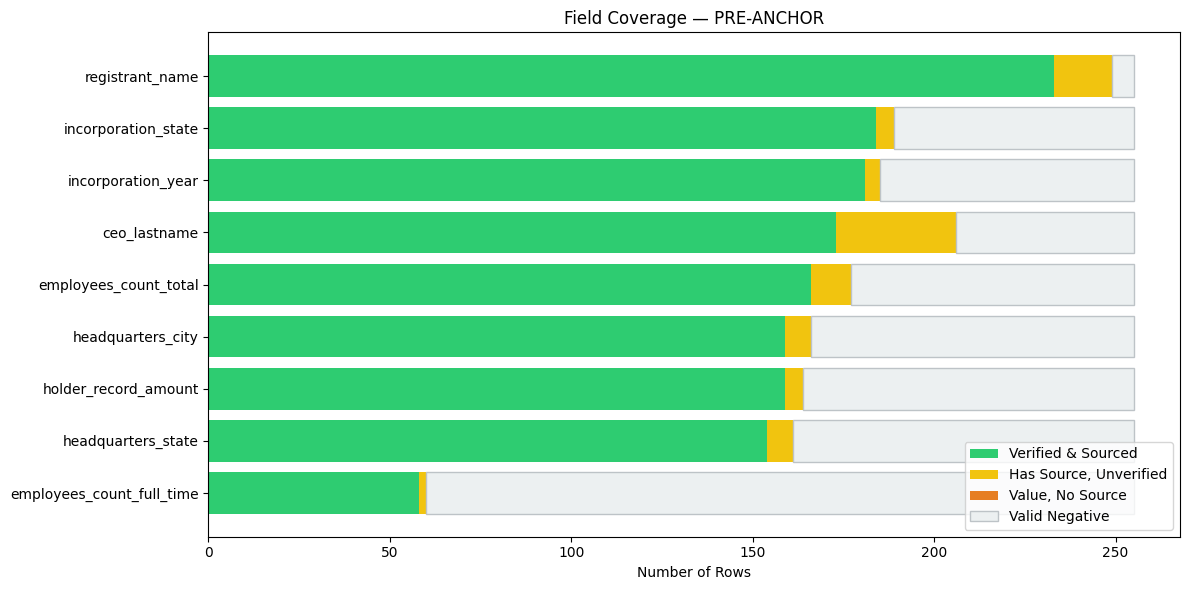

In [17]:
print("Running pre-anchor verification...")
df = run_verification(df, FIELD_IDS, SECTION_KEYS)

pre_stats = compute_field_stats(df, FIELD_IDS, "PRE-ANCHOR")
plot_field_coverage(pre_stats, "PRE-ANCHOR")

### Verify and Anchor Loop

In [18]:
@dataclass
class MatchResult:
    """Result of matching a source sentence against filing sections."""

    score: float  # 0.0–1.0 (1.0 = exact)
    section: str | None  # e.g. "section_1"
    matched_text: str | None  # Exact text from the section
    tier: str  # "exact", "fingerprint", "fuzzy", or "none"

In [19]:
def fingerprint(text: str) -> str:
    """Strip non-alphanumeric chars and lowercase for robust comparison."""
    if not isinstance(text, str):
        return ""
    return re.sub(r"[\W_]+", "", text).lower()

In [20]:
_ABBREVIATIONS = re.compile(
    r"\b(?:Inc|Corp|Co|Ltd|Mr|Mrs|Dr|No|vs|etc|U\.S|Cal|Fla|Ill|"
    r"Mass|Minn|Tex|Rev|Vol|Art|Sec|Par|"
    r"Jan|Feb|Mar|Apr|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\.",
    re.IGNORECASE,
)
_SENTINEL = "\x00"


def split_sentences(text: str) -> list[str]:
    """Split text into sentences, protecting common abbreviation periods."""
    if not isinstance(text, str) or not text.strip():
        return []
    protected = _ABBREVIATIONS.sub(lambda m: m.group(0).replace(".", _SENTINEL), text)
    parts = re.split(r"(?<=[.!?])\s+(?=[A-Z])", protected)
    return [p.replace(_SENTINEL, ".").strip() for p in parts if p.strip()]

In [21]:
def _try_exact_match(
    sentence: str,
    section_text: str,
    section_name: str,
    short_threshold: int,
) -> MatchResult | None:
    """Tier 1: Check for exact substring match (score=1.0)."""
    if sentence not in section_text:
        return None
    if len(sentence) < short_threshold:
        sentences = split_sentences(section_text)
        containing = [s for s in sentences if sentence in s]
        if containing:
            return MatchResult(1.0, section_name, min(containing, key=len), "exact")
    return MatchResult(1.0, section_name, sentence, "exact")

In [22]:
def _try_fingerprint_match(
    sentence: str,
    fp_sentence: str,
    section_text: str,
    section_name: str,
) -> MatchResult | None:
    """Tier 2: Fingerprint match (score=0.9). Tries to recover exact text via fuzzy."""
    if not fp_sentence:
        return None
    if fp_sentence not in fingerprint(section_text):
        return None
    # Fingerprint matched — try to find the actual sentence via Levenshtein
    sentences = split_sentences(section_text)
    best_sent, best_ratio = None, 0.0
    for s in sentences:
        ratio = Levenshtein.ratio(sentence, s)
        if ratio > best_ratio:
            best_ratio = ratio
            best_sent = s
    matched = best_sent if (best_sent and best_ratio > 0.5) else sentence
    return MatchResult(0.9, section_name, matched, "fingerprint")

In [23]:
def _try_fuzzy_match(
    sentence: str,
    section_text: str,
    section_name: str,
) -> MatchResult | None:
    """Tier 3: Best fuzzy match among split sentences (score=Levenshtein ratio)."""
    sentences = split_sentences(section_text)
    best_sent, best_ratio = None, 0.0
    for s in sentences:
        ratio = Levenshtein.ratio(sentence, s)
        if ratio > best_ratio:
            best_ratio = ratio
            best_sent = s
    if best_sent and best_ratio > 0.0:
        return MatchResult(best_ratio, section_name, best_sent, "fuzzy")
    return None

In [24]:
def scored_verify_in_sections(
    row: pd.Series,
    sentence: str,
    section_keys: list[str],
    short_threshold: int = SHORT_EVIDENCE_THRESHOLD,
) -> MatchResult:
    """
    Score-verify a source sentence against all sections.
    Tries exact → fingerprint → fuzzy per section, returns the best overall match.
    """
    if not isinstance(sentence, str) or pd.isna(sentence) or not sentence.strip():
        return MatchResult(0.0, None, None, "none")

    best = MatchResult(0.0, None, None, "none")
    fp_sentence = fingerprint(sentence)

    for sec_name in section_keys:
        sec_text = row.get(sec_name)
        if not isinstance(sec_text, str) or pd.isna(sec_text):
            continue

        # Tier 1 — exact (return immediately if found)
        exact = _try_exact_match(sentence, sec_text, sec_name, short_threshold)
        if exact:
            return exact

        # Tier 2 — fingerprint
        fp = _try_fingerprint_match(sentence, fp_sentence, sec_text, sec_name)
        if fp and fp.score > best.score:
            best = fp
            continue  # Don't fall through to fuzzy for this section

        # Tier 3 — fuzzy
        fuzzy = _try_fuzzy_match(sentence, sec_text, sec_name)
        if fuzzy and fuzzy.score > best.score:
            best = fuzzy

    return best

In [25]:
def _anchor_single_field(
    df: pd.DataFrame,
    field_id: str,
    section_keys: list[str],
    fuzzy_threshold: float,
    short_threshold: int,
) -> tuple[int, int, list[str]]:
    """
    Run verify-and-anchor for one field across all rows.

    Returns:
        (anchored_count, failed_count, diff_lines)
    """
    value_col = f"{field_id}_value"
    source_col = f"{field_id}_source_sentence"
    section_col = f"{field_id}_section"

    anchored, already, failed, changed = 0, 0, 0, 0
    diff_lines: list[str] = []

    for idx in range(len(df)):
        row = df.iloc[idx]
        if pd.isna(row.get(value_col)):
            continue

        source = row.get(source_col)
        if pd.isna(source) or not isinstance(source, str) or not str(source).strip():
            failed += 1
            continue

        source = str(source).strip()
        result = scored_verify_in_sections(row, source, section_keys, short_threshold)

        if result.score >= fuzzy_threshold and result.matched_text:
            new_source = result.matched_text.strip()
            if new_source != source:
                changed += 1
                anchored += 1
                diff = difflib.unified_diff(
                    source.splitlines(keepends=True),
                    new_source.splitlines(keepends=True),
                    fromfile=f"{field_id}[row {idx}] OLD",
                    tofile=f"{field_id}[row {idx}] NEW ({result.tier},{result.score:.3f})",
                    lineterm="",
                )
                diff_lines.extend(diff)
                diff_lines.append("")
                df.at[df.index[idx], source_col] = new_source
            else:
                already += 1
            df.at[df.index[idx], section_col] = result.section
        else:
            failed += 1
            df.at[df.index[idx], section_col] = None

    print(
        f"  {field_id:30s} "
        f"anchored={anchored:>3d}  already={already:>3d}  "
        f"changed={changed:>3d}  failed={failed:>3d}"
    )
    return anchored, failed, diff_lines

In [26]:
def verify_and_anchor(
    df: pd.DataFrame,
    field_ids: list[str],
    section_keys: list[str],
    max_passes: int = MAX_ANCHOR_PASSES,
    fuzzy_threshold: float = 0.7,
    short_threshold: int = SHORT_EVIDENCE_THRESHOLD,
    log_dir: str | None = None,
) -> pd.DataFrame:
    """
    Iteratively verify and anchor _source_sentence values against section columns.
    Runs up to max_passes, stopping early if no improvement.
    Modifies _source_sentence and _section columns only.
    """
    for pass_num in range(1, max_passes + 1):
        print(f"\n{'='*60}")
        print(f"  ANCHOR PASS {pass_num}/{max_passes}")
        print(f"{'='*60}")

        total_anchored = 0
        all_diffs: list[str] = []

        for field_id in field_ids:
            anchored, _, diffs = _anchor_single_field(
                df, field_id, section_keys, fuzzy_threshold, short_threshold
            )
            total_anchored += anchored
            all_diffs.extend(diffs)

        if log_dir and all_diffs:
            log_path = os.path.join(log_dir, f"anchor_pass_{pass_num}_diffs.txt")
            with open(log_path, "w", encoding="utf-8") as f:
                f.write("\n".join(all_diffs))
            print(f"\n  Diff log → {log_path}")

        print(f"\n  Pass {pass_num}: {total_anchored} sentence(s) changed")

        if total_anchored == 0:
            print("  No improvement — stopping early.")
            break

    return df


In [27]:
print("=== Step 5: Verify & Anchor Loop ===")
df = verify_and_anchor(df, FIELD_IDS, SECTION_KEYS, log_dir=LOG_DIR)
print("Done.")


=== Step 5: Verify & Anchor Loop ===

  ANCHOR PASS 1/3
  ceo_lastname                   anchored= 19  already=178  changed= 19  failed=  9
  employees_count_full_time      anchored=  2  already= 58  changed=  2  failed=  0
  employees_count_total          anchored=  7  already=166  changed=  7  failed=  4
  headquarters_city              anchored=  7  already=159  changed=  7  failed=  0
  headquarters_state             anchored=  7  already=154  changed=  7  failed=  0
  holder_record_amount           anchored=  4  already=160  changed=  4  failed=  0
  incorporation_state            anchored=  4  already=185  changed=  4  failed=  0
  incorporation_year             anchored=  4  already=181  changed=  4  failed=  0
  registrant_name                anchored= 21  already=228  changed= 21  failed=  0

  Diff log → ../../data/logs/difflib\anchor_pass_1_diffs.txt

  Pass 1: 75 sentence(s) changed

  ANCHOR PASS 2/3
  ceo_lastname                   anchored=  0  already=197  changed=  0  

### Post Anchor Analysis and Visualization

Running post-anchor verification...

  POST-ANCHOR — Field Coverage Summary
  ceo_lastname                    verified=192  unverified= 14  no_source=  0  negative= 49  coverage=100%
  employees_count_full_time       verified= 60  unverified=  0  no_source=  0  negative=195  coverage=100%
  employees_count_total           verified=173  unverified=  4  no_source=  0  negative= 78  coverage=100%
  headquarters_city               verified=166  unverified=  0  no_source=  0  negative= 89  coverage=100%
  headquarters_state              verified=161  unverified=  0  no_source=  0  negative= 94  coverage=100%
  holder_record_amount            verified=163  unverified=  1  no_source=  0  negative= 91  coverage=100%
  incorporation_state             verified=188  unverified=  1  no_source=  0  negative= 66  coverage=100%
  incorporation_year              verified=185  unverified=  0  no_source=  0  negative= 70  coverage=100%
  registrant_name                 verified=247  unverified=  2  no_s

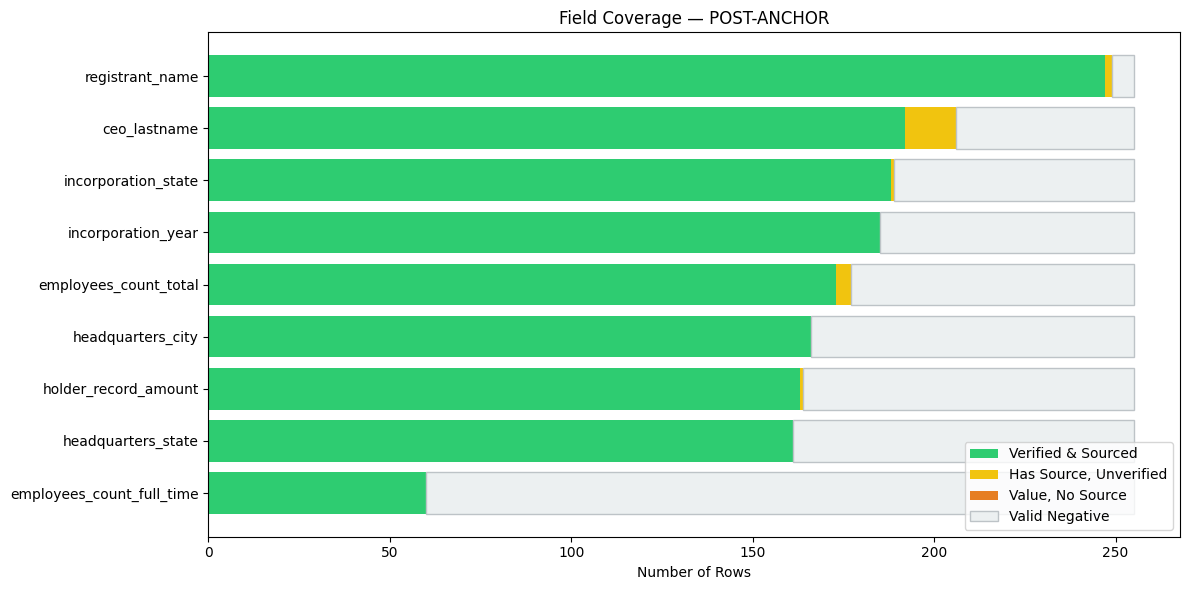


  ANCHORING DELTA — Pre vs Post
  ceo_lastname                    verified 173 → 192 (+19)  |  coverage 100% → 100%
  employees_count_full_time       verified  58 →  60 (+2)  |  coverage 100% → 100%
  employees_count_total           verified 166 → 173 (+7)  |  coverage 100% → 100%
  headquarters_city               verified 159 → 166 (+7)  |  coverage 100% → 100%
  headquarters_state              verified 154 → 161 (+7)  |  coverage 100% → 100%
  holder_record_amount            verified 159 → 163 (+4)  |  coverage 100% → 100%
  incorporation_state             verified 184 → 188 (+4)  |  coverage 100% → 100%
  incorporation_year              verified 181 → 185 (+4)  |  coverage 100% → 100%
  registrant_name                 verified 233 → 247 (+14)  |  coverage 100% → 100%



In [28]:
# === Step 6: Post-Anchor Analysis ===
print("Running post-anchor verification...")
df = run_verification(df, FIELD_IDS, SECTION_KEYS)

post_stats = compute_field_stats(df, FIELD_IDS, "POST-ANCHOR")
plot_field_coverage(post_stats, "POST-ANCHOR")
print_coverage_delta(pre_stats, post_stats)


### Clean Output One More Time And Save

In [29]:
df = standardize_sentinels(df, FIELD_IDS)

In [30]:
KEEP_SUFFIXES = ("_value", "_source_sentence", "_section")
META_COLS = ["filename", "cik", "year"]


def build_keep_cols(
    df_cols: list[str],
    field_ids: list[str],
    section_keys: list[str],
    meta_cols: list[str],
    keep_suffixes: tuple[str, ...],
) -> list[str]:
    """Return the ordered list of columns to keep in the final output.

    Args:
        df_cols:      All column names in the current DataFrame.
        field_ids:    List of field identifiers (e.g. 'ceo_lastname').
        section_keys: List of section column names (e.g. 'section_1').
        meta_cols:    Metadata columns to always keep.
        keep_suffixes: Per-field column suffixes to keep.

    Returns:
        Ordered list of column names to retain.
    """
    kept: list[str] = []

    # Metadata
    kept += [c for c in meta_cols if c in df_cols]

    # Section text columns
    kept += [c for c in section_keys if c in df_cols]

    # Per-field value / source_sentence / section
    for field in field_ids:
        for suffix in keep_suffixes:
            col = f"{field}{suffix}"
            if col in df_cols:
                kept.append(col)

    return kept


In [31]:
keep_cols = build_keep_cols(
    df_cols=df.columns.tolist(),
    field_ids=FIELD_IDS,
    section_keys=SECTION_KEYS,
    meta_cols=META_COLS,
    keep_suffixes=KEEP_SUFFIXES,
)

In [32]:

# ── 2. Safety check ──────────────────────────────────────────────────────────
def run_safety_check(
    df: "pd.DataFrame",
    keep_cols: list[str],
    field_ids: list[str],
    original_row_count: int,
) -> None:
    """Raise AssertionError if safety invariants are violated.

    Args:
        df:                 The DataFrame (before column drop).
        keep_cols:          Planned output columns.
        field_ids:          Expected field identifiers.
        original_row_count: Row count at the start of the pipeline.

    Side effects:
        Raises AssertionError on any violation.
    """
    keep_set = set(keep_cols)

    missing_value = [f for f in field_ids if f"{f}_value" not in keep_set]
    missing_source = [f for f in field_ids if f"{f}_source_sentence" not in keep_set]

    assert not missing_value, f"Missing _value columns for:           {missing_value}"
    assert not missing_source, f"Missing _source_sentence columns for: {missing_source}"
    assert (
        len(df) == original_row_count
    ), f"Row count changed: expected {original_row_count}, got {len(df)}"
    print(
        f"Safety check passed — {len(df)} rows, all _value & _source_sentence cols present."
    )


In [33]:
run_safety_check(df, keep_cols, FIELD_IDS, original_row_count=ORIGINAL_ROW_COUNT)

Safety check passed — 255 rows, all _value & _source_sentence cols present.


In [34]:
df_out = df[keep_cols].copy()

In [35]:
# Save
timestamp = datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
out_fname = f"cleaned_EDGAR_gt_{timestamp}.csv"
out_path = os.path.join(OUTPUT_DIR, out_fname)

os.makedirs(OUTPUT_DIR, exist_ok=True)
df_out.to_csv(out_path, index=False)


In [36]:
print(f"Saved to : {out_path}")
print(f"Shape    : {df_out.shape[0]} rows x {df_out.shape[1]} columns")
print(f"Kept columns ({len(keep_cols)}):")
for col in keep_cols:
    print(f"   {col}")


Saved to : ../../data/clean_ground_truth\cleaned_EDGAR_gt_02-21-2026_22-31-13.csv
Shape    : 255 rows x 50 columns
Kept columns (50):
   filename
   cik
   year
   section_1
   section_1A
   section_1B
   section_2
   section_3
   section_4
   section_5
   section_6
   section_7
   section_7A
   section_8
   section_9
   section_9A
   section_9B
   section_10
   section_11
   section_12
   section_13
   section_14
   section_15
   ceo_lastname_value
   ceo_lastname_source_sentence
   ceo_lastname_section
   employees_count_full_time_value
   employees_count_full_time_source_sentence
   employees_count_full_time_section
   employees_count_total_value
   employees_count_total_source_sentence
   employees_count_total_section
   headquarters_city_value
   headquarters_city_source_sentence
   headquarters_city_section
   headquarters_state_value
   headquarters_state_source_sentence
   headquarters_state_section
   holder_record_amount_value
   holder_record_amount_source_sentence
   holder